<a href="https://colab.research.google.com/github/supreetsandhu/Homelessness/blob/main/DATA_3320_Homelessness_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This project will look at the homelessness in the USA. The U.S. Department of Housing and Urban Development (HUD) argues that local market factors are determiants and factors in homelessness. This project is directly motivated by the claim by HUD. This project will look at other models that correlate to local market factors and homelessness, to see if we can produce a model that out peforms the model created by HUD.

## Import libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Import additional libraries
#seaborn is a data visualization library built on matplotlib
import seaborn as sns 
#set the plotting style 
sns.set_style("whitegrid")

#Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from scipy.stats import uniform, randint
import xgboost as xgb

#Models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
import statsmodels.api as sm

#Model metrics
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix,  mean_absolute_error

#Missing data
import missingno as msno

import graphviz
from sklearn.preprocessing import RobustScaler





## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

We are going to read in our data.

In [103]:
df =pd.read_csv('https://raw.githubusercontent.com/supreetsandhu/Homelessness/main/homeless_data_prep%20(14).csv')
     

Our additional step is including state federal funding. We wwill read in the data for state funding.

In [104]:
state_data = pd.read_csv('https://raw.githubusercontent.com/supreetsandhu/Homelessness/main/federal-aid-by-state-2023.csv')

We will need to first create a new column with the state from the coc number. So we can join the two data sets on the state.

In [105]:
df['state'] = [df['coc_number'].str.split('-')[n][0] for n in range(374)]

We  will join the data sets.

In [106]:
df = df.merge(state_data, on='state', how='left')

We will need to clean the data so that the data set only has quality data that we can work with.

In [107]:
df = df.loc[df['totalFederalFunding'].notna()]

##### $\rightarrow$ Review the contents of the data set.

In [108]:
df

,coc_number,total_homeless,total_population,house_price_index_2009,log_median_rent,utility_costs,percentage_owners_cost_burden_2016,percentage_renters_severe_cost_burden_2016,share_renters_2016,rental_vacancy_rate,...,percent_asian,percent_pacific_islander,percent_population_0_19,percent_population_65_plus,percent_female_population,state,federalFunding,totalFederalFunding,benefitsRecipients,HouseholdIncome
0,AK-500,1128.0,297376,11.743647,2.438863,8.500000,15.334315,21.014816,39.727921,4.817212,...,0.093952,0.024387,0.269161,0.099140,0.489629,AK,7048.0,1.300000e+10,10.8,77790.0
1,AK-501,717.0,444146,9.042710,2.249699,14.607715,13.311670,19.364561,33.922234,7.000090,...,0.040104,0.004593,0.278562,0.109905,0.467752,AK,7048.0,1.300000e+10,10.8,77790.0
2,AL-500,1092.0,958302,-0.852477,1.862248,19.492331,12.188416,24.962938,31.769621,8.249993,...,0.016632,0.000311,0.256410,0.149058,0.521677,AL,6694.0,6.580000e+10,14.0,52035.0
3,AL-501,606.0,622361,-8.507004,1.858394,18.899839,12.539132,27.231920,32.109203,19.424814,...,0.016889,0.000382,0.254735,0.167126,0.519669,AL,6694.0,6.580000e+10,14.0,52035.0
4,AL-502,155.0,265264,0.751167,1.362010,18.803186,10.374694,21.588467,27.708206,7.218406,...,0.004901,0.000471,0.236545,0.190708,0.513937,AL,6694.0,6.580000e+10,14.0,52035.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,WV-500,118.0,142272,8.888932,1.459895,16.585392,8.072322,23.992035,27.521181,8.022702,...,0.005103,0.000098,0.216459,0.213703,0.511886,WV,7283.0,2.460000e+10,16.8,48037.0
370,WV-501,205.0,136349,2.793695,1.595035,17.695057,9.171934,31.546597,34.475803,8.452822,...,0.009916,0.000132,0.232763,0.185069,0.510895,WV,7283.0,2.460000e+10,16.8,48037.0
371,WV-503,319.0,274427,3.041601,1.649177,17.768978,8.460396,23.093138,27.259258,6.982692,...,0.009529,0.000255,0.230819,0.188192,0.514122,WV,7283.0,2.460000e+10,16.8,48037.0
372,WV-508,667.0,1275589,4.995708,1.587101,16.804708,9.594313,24.319666,26.778641,7.289378,...,0.007858,0.000220,0.229239,0.185788,0.502335,WV,7283.0,2.460000e+10,16.8,48037.0


## State your questions

##### $\rightarrow$ Is there a better model for predicting homelessness rates based on local housing market factors? What local housing market factors are best associated with prediciting rates of homelessness? Are federal state funding realted to the rates of homelessness?

# Analysis

We will split the data into a training set.

In [109]:
X = df[df.columns.difference(['coc_number', 'rate_homeless', "total_population", "total_homeless", "state"])]
y = df['rate_homeless']

We will only keep 20% of the data for testing.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 10)

Examine the shape of the training data matrix of predictors.

In [111]:
print(X_train.shape, np.round(X_train.shape[0]/X_train.shape[1]))

(298, 41) 7.0


we will want to center the variables using the median and scale with the inter-quartile range. We use the RobustScaler here because many variables have skewed distributions.

We will define the scaler using only the training data. If we want to validation set approach to work, we can not include the prvious knowledge of the validation set and the set's properties into how we are building our model.


In [112]:
scaler = RobustScaler().fit(X_train)

We will perform the scaling transform on the predictors in the training and testing sets.

In [113]:
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

We will now fit the model to the train set that we have made.

In [114]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

We are going to display all of the predictor name and the p0value of the estimated coefficent.

In [115]:
variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(index = variables, data = {'p-value':model.pvalues.values.round(3), 'significant': model.pvalues.values < 0.05})

,p-value,significant
intercept,0.000,True
HUD_unit_occupancy_rate,0.050,False
HouseholdIncome,0.282,False
average_Jan_temperature,0.481,False
average_summer_temperature,0.412,False
benefitsRecipients,0.489,False
city_or_urban,0.907,False
federalFunding,0.646,False
gini_coefficient_2016,0.264,False
high_housing_density,0.001,True


This shows that there are a lot of variables in this model. We are  going to have to use regularization methods and dimensionality reduction methods to build a model. We are going to utilize regularization through the Lasso and ridge method.

We will use the model to predict the test data and compute the MSE, RMSE, and $R^2$.

In [116]:
MSE = mean_squared_error(y_test, model.predict(sm.add_constant(X_test)))
RMSE = np.sqrt(MSE)
R_squared = r2_score(y_test, model.predict(sm.add_constant(X_test)))

print('MSE =', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE = 278.651  RMSE = 16.693  R-squared = 0.323


The r-squared value is relatively low which means that the variation in the data is relatively low.  

## Lasso

Lasso regression finds the parameters in the linear model by minimizing a penalized squared error:

$$C(\boldsymbol{\beta}) = \sum_{i=1}^n(y_i - \beta_{0} - \sum_{j=1}^p\beta_{j}x_{ij})^2 + \alpha \sum_{j=1}^p|\beta_{j}| = \text{RSS} + \alpha \sum_{j=1}^p|\beta_{j}|$$

There is a hyperparameter $\alpha$ that influences the performance. We will use cross validation to determine the best value.

We are first going to create an array of possible  $\alpha$ values that we can use in the Lasso regression.

In [117]:
alphas = 10**np.linspace(-4,0,10)

For all of the  $\alpha$ values that we have just calculated we are going to see the correlation between the alpha's and the coefficents.

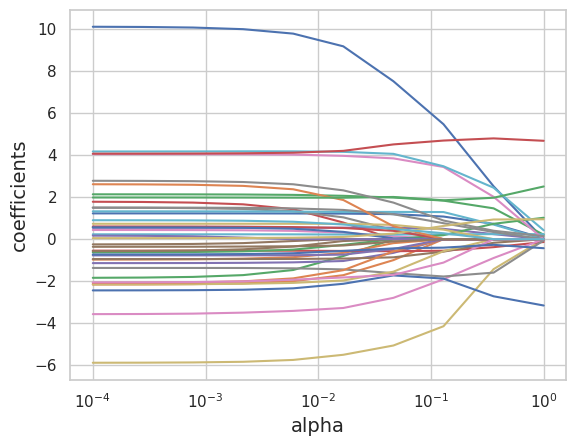

In [118]:
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

As the alpha's increase in value, some of the coefficents converge to zero.

We will do a 5-fold cross validation to find $\alpha$.

In [119]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)

We will fit the set to the training data.

In [120]:
lassocv.fit(X_train, y_train)
lassocv.alpha_

0.25769158359153116

We will graph the mean square error on each fold. We are looking for how well the average of each fold to the estimate from the alpha variable.

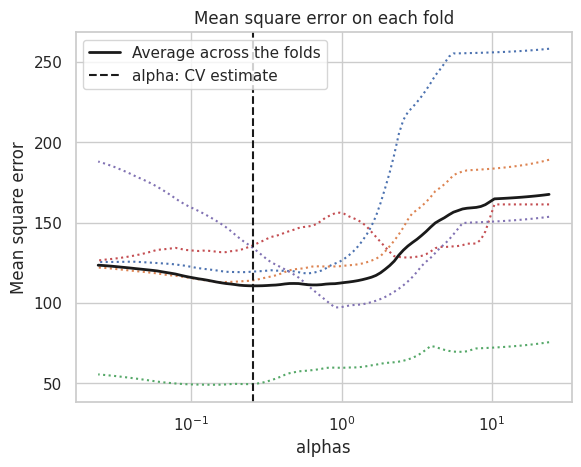

In [121]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, ":")
plt.plot(
    lassocv.alphas_ ,
    lassocv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lassocv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight");

We can see that there is a lot of variablity in this data set. The alpha CV estimate to the average across each fold is not extremely correlated and vary a lot.

We will fit the Lasso model on the training data with the best $\alpha$ and examine the coefficents tot see what local  market variable fits best for the  $\alpha$ we have calculated.

In [122]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)

We will look at each local market factor variable and the estimated coefficent.

In [123]:
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients.round(2), index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,13.23
HUD_unit_occupancy_rate,0.85
HouseholdIncome,0.00
average_Jan_temperature,-0.00
average_summer_temperature,-0.00
benefitsRecipients,-0.00
city_or_urban,0.00
federalFunding,-0.00
gini_coefficient_2016,0.00
high_housing_density,-2.62


We will know use the lasso model to predict the test data and we will compute the MSE, RMSE and R^2.

In [124]:
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 271.438  RMSE = 16.475  R-squared = 0.34


The r-squared value is realtively low which shows that our model is somewhat accurate. The RMSE is around 16.475 which means on average the prediction is off by about 16.475 people for the rate of homeless per 10,000 people.

We will make a scatterplot of the rate of homelessness to the predicited rate of homelessness.

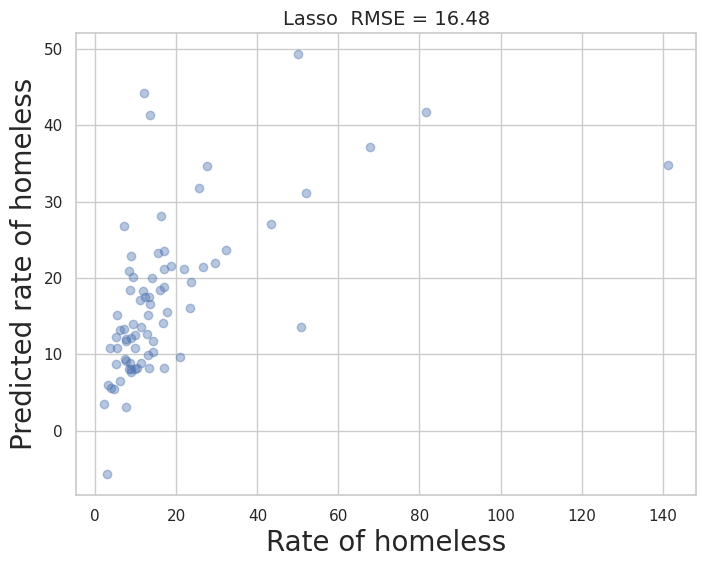

In [125]:
plt.figure(figsize=(8,6))

plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)

plt.xlabel('Rate of homeless',fontsize = 20)
plt.ylabel('Predicted rate of homeless',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14);

The predicted values to the actual values are relatively close to each other. There are some outliers.

## Ridge Regression

Ridge regression finds the parameters in the linear model by minimizing a penalized squared error:

$$C(\boldsymbol{\beta}) = \sum_{i=1}^n(y_i - \beta_{0} - \sum_{j=1}^p\beta_{j}x_{ij})^2 + \alpha \sum_{j=1}^p\beta_{j}^2 = \text{RSS} + \alpha \sum_{j=1}^p\beta_{j}^2$$

There is a hyperparameter $\alpha$ that influences the performance. We will use cross validation to determine the best value.

We will create an array of alphas that we can use for the Ridge regression.

In [126]:
alphas = 10**np.linspace(-3,5,20)

We need to understand how the $\alpha$ fits.

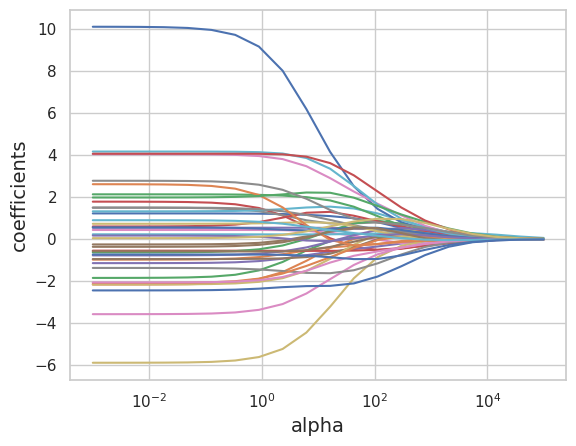

In [127]:
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);


As a $\alpha$ increases, all coefficents are scaled then to be smaller. So we can see as the alpha increases, the  are scaled then to be smaller in this graph.

We will do cross validation to find the best alpha for the best Ridge regression. We will do a five fold regression.

In [128]:
ridgecv = RidgeCV(alphas = alphas, cv = 5, scoring = 'neg_mean_squared_error')

ridgecv.fit(X_train, y_train);

We will print what alpha is the best.

In [129]:
ridgecv.alpha_

112.88378916846884

We will fit the regression model on the training data while using the best alpha and then examine the coefficents.

In [130]:
ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(X_train, y_train)

In [131]:
coefficients = ridge_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, ridge_reg.intercept_.round(3))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients, index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,12.522
HUD_unit_occupancy_rate,0.810
HouseholdIncome,0.181
average_Jan_temperature,0.091
average_summer_temperature,-0.515
benefitsRecipients,-0.347
city_or_urban,0.493
federalFunding,-0.020
gini_coefficient_2016,0.796
high_housing_density,-0.856


we can see what coefficents are the best to use for our model.

In [132]:
MSE_ridge = mean_squared_error(y_test, ridge_reg.predict(X_test))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_test, ridge_reg.predict(X_test))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 266.048  RMSE = 16.311  R-squared = 0.354


We know have our coefficetns that are fit from the training data from doing a ridge regression. We will make a scatterplot of the predicited rate of homelessness to the actual rate of homelessness.

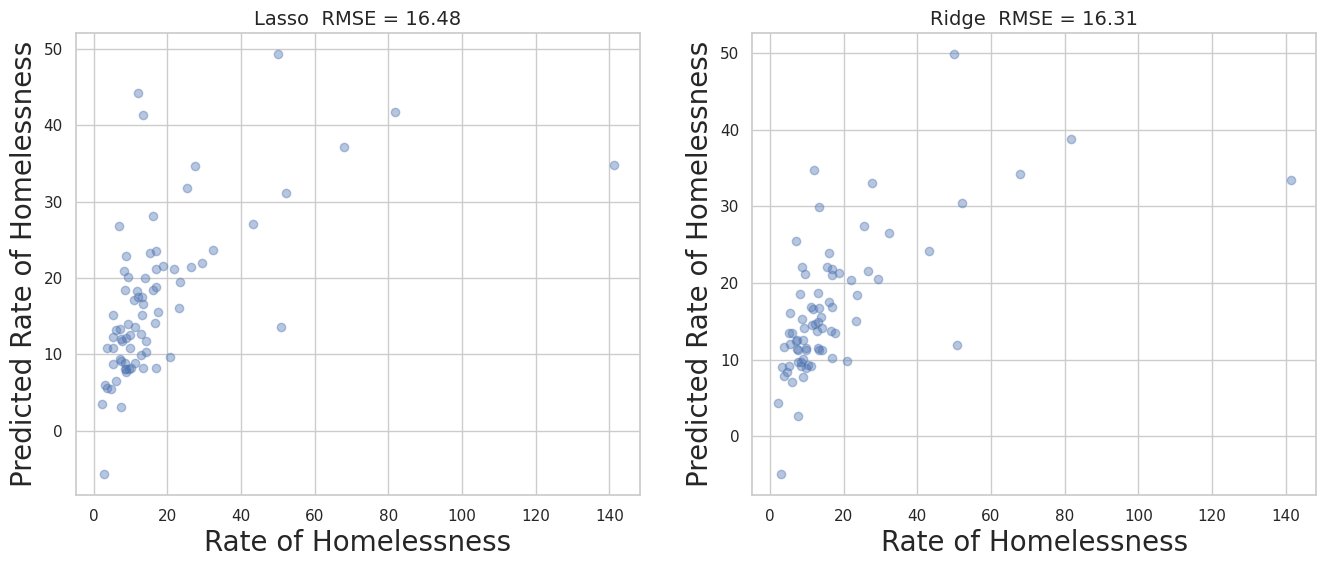

In [133]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(y_test, lasso_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('Rate of Homelessness',fontsize = 20)
plt.ylabel('Predicted Rate of Homelessness',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14)

plt.subplot(1,2,2)
plt.plot(y_test, ridge_reg.predict(X_test),'o', alpha = 0.4)
plt.xlabel('Rate of Homelessness',fontsize = 20)
plt.ylabel('Predicted Rate of Homelessness',fontsize = 20)
plt.title('Ridge' + ' ' + ' RMSE = ' + str(RMSE_ridge.round(2)),fontsize = 14);

plt.subplots_adjust(hspace = 0.5)

We can see that both the lasso and the ridge regression sets have relatively accurate predictions to the actual rate of homelessness.

## XGBoost ( eXtreme Gradient Boosting)

We need to first define our x value from the scaler that we defined earlier that was based on our training data.

In [134]:
#X = pd.DataFrame(data=scaler.transform(X), columns=X.columns.values, index=X.index)
#X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns.values)
#X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns.values)

We will fit our model to the y value.

In [135]:
model = sm.OLS(y, sm.add_constant(X)).fit() 

We will be using muitple variables. So we will display the predictor name 
and the p-value and the estimated coefficent.

In [136]:
variables = X.columns
variables = np.insert(variables, 0, 'intercept')

results = pd.DataFrame(index = variables, 
             data = {'p-value':model.pvalues.values.round(3), 
                     'significant':model.pvalues.values < 0.05,
                     'coefficient':model.params.values.round(2),
                     'abs_coefficient':np.abs(model.params.values.round(2))})

results.sort_values(by = 'abs_coefficient', ascending=False)

,p-value,significant,coefficient,abs_coefficient
percent_pacific_islander,0.012,True,310.07,310.07
percent_female_population,0.136,False,-143.11,143.11
percent_black,0.008,True,-34.17,34.17
percent_asian,0.106,False,-34.15,34.15
log_median_rent,0.002,True,24.21,24.21
percent_population_65_plus,0.706,False,-16.81,16.81
percent_latino_hispanic,0.391,False,-9.27,9.27
percent_population_0_19,0.908,False,6.78,6.78
percentage_excessive_drinking,0.836,False,-6.50,6.50
migration_4_year_change,0.001,True,3.59,3.59


We have too many variables that we are using to predict in our model We are over fitting. So we will use XGBoost for our dimensionality reduction method.

We will use our model to predict our test data. 

In [137]:
y_pred_lr = model.predict(sm.add_constant(X))

In [138]:
MSE = mean_squared_error(y, y_pred_lr)
RMSE = np.sqrt(MSE)
R_squared = r2_score(y, y_pred_lr)

print('MSE =', MSE.round(3), ' RMSE =', RMSE.round(3), ' R-squared =', R_squared.round(3))

MSE = 92.511  RMSE = 9.618  R-squared = 0.575


The RSME is about how far off you are on average. So in this case, when we calculating the rate of homeless per 10,000 residents we are off by about 10 people. The R-square is 0.575 which is realtive good r-squared value for how accurate the model is.

We will plot our predicted rate now and the actual rate of homelessness.

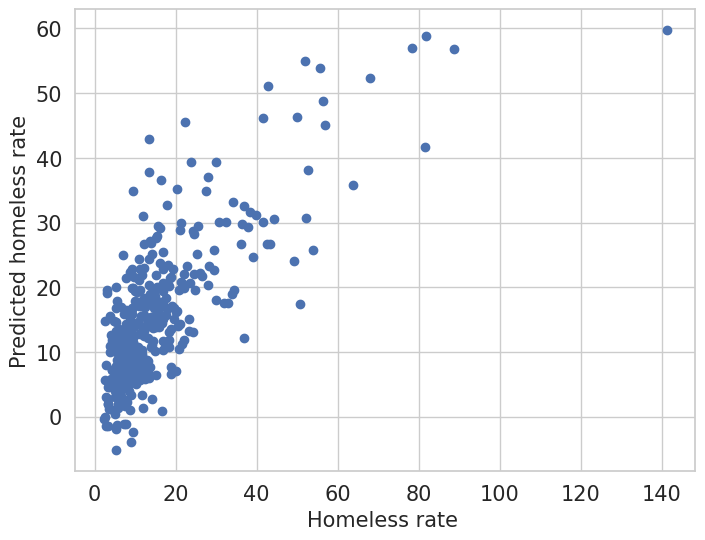

In [139]:
plt.figure(figsize = (8,6))

plt.plot(y, y_pred_lr, 'o');

plt.xlabel('Homeless rate ', fontsize = 15)
plt.ylabel('Predicted homeless rate', fontsize = 15)

plt.tick_params(labelsize = 15)

Our model is faily accurate with predicting the rate of homeless. There are some outliers.

We are now ready for the XGBoost method in our regression. We will use cross-validation to find the best parameters for an XGBoost model.

In [140]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb78ab3ad70>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb78b916bf0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb78d41c340>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb78b915e40>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

We will first seach for the best parameters.

In [141]:
search.best_params_

{'colsample_bytree': 0.7926890228503775,
 'gamma': 0.465428007638516,
 'learning_rate': 0.31362747158698445,
 'max_depth': 4,
 'n_estimators': 101,
 'subsample': 0.900858009158222}

We will create uor xgb model from the xgb regressor.

In [142]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror")

We will set our model to the best parameters that we declared earlier.

In [143]:
model_xgb.set_params(**search.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7926890228503775, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.465428007638516, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.31362747158698445, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=101, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Fit the model on the training data

In [144]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7926890228503775, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.465428007638516, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.31362747158698445, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=101, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [145]:
type(X_train)

numpy.ndarray

we will predict the test data.

In [146]:
y_pred_xgb = model_xgb.predict(X_test)

We will now plot the test values of the y to the predicted values.

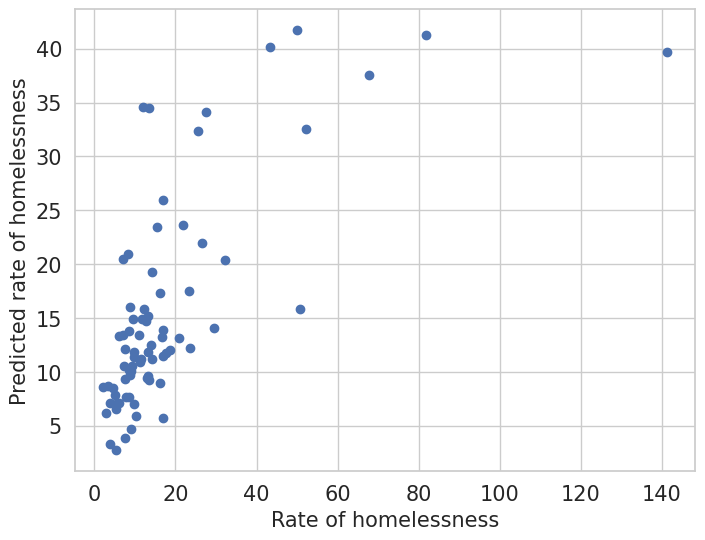

In [147]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_xgb, 'o');

plt.xlabel('Rate of homelessness', fontsize = 15)
plt.ylabel('Predicted rate of homelessness', fontsize = 15)

plt.tick_params(labelsize = 15)

We can see that our rate of homelessness to our predicted rate of homelessness is realtive similar. This model does a somewhat well job of modeling the actual rate of homelessness.

We will plot the variable importances for the XgBoost Model

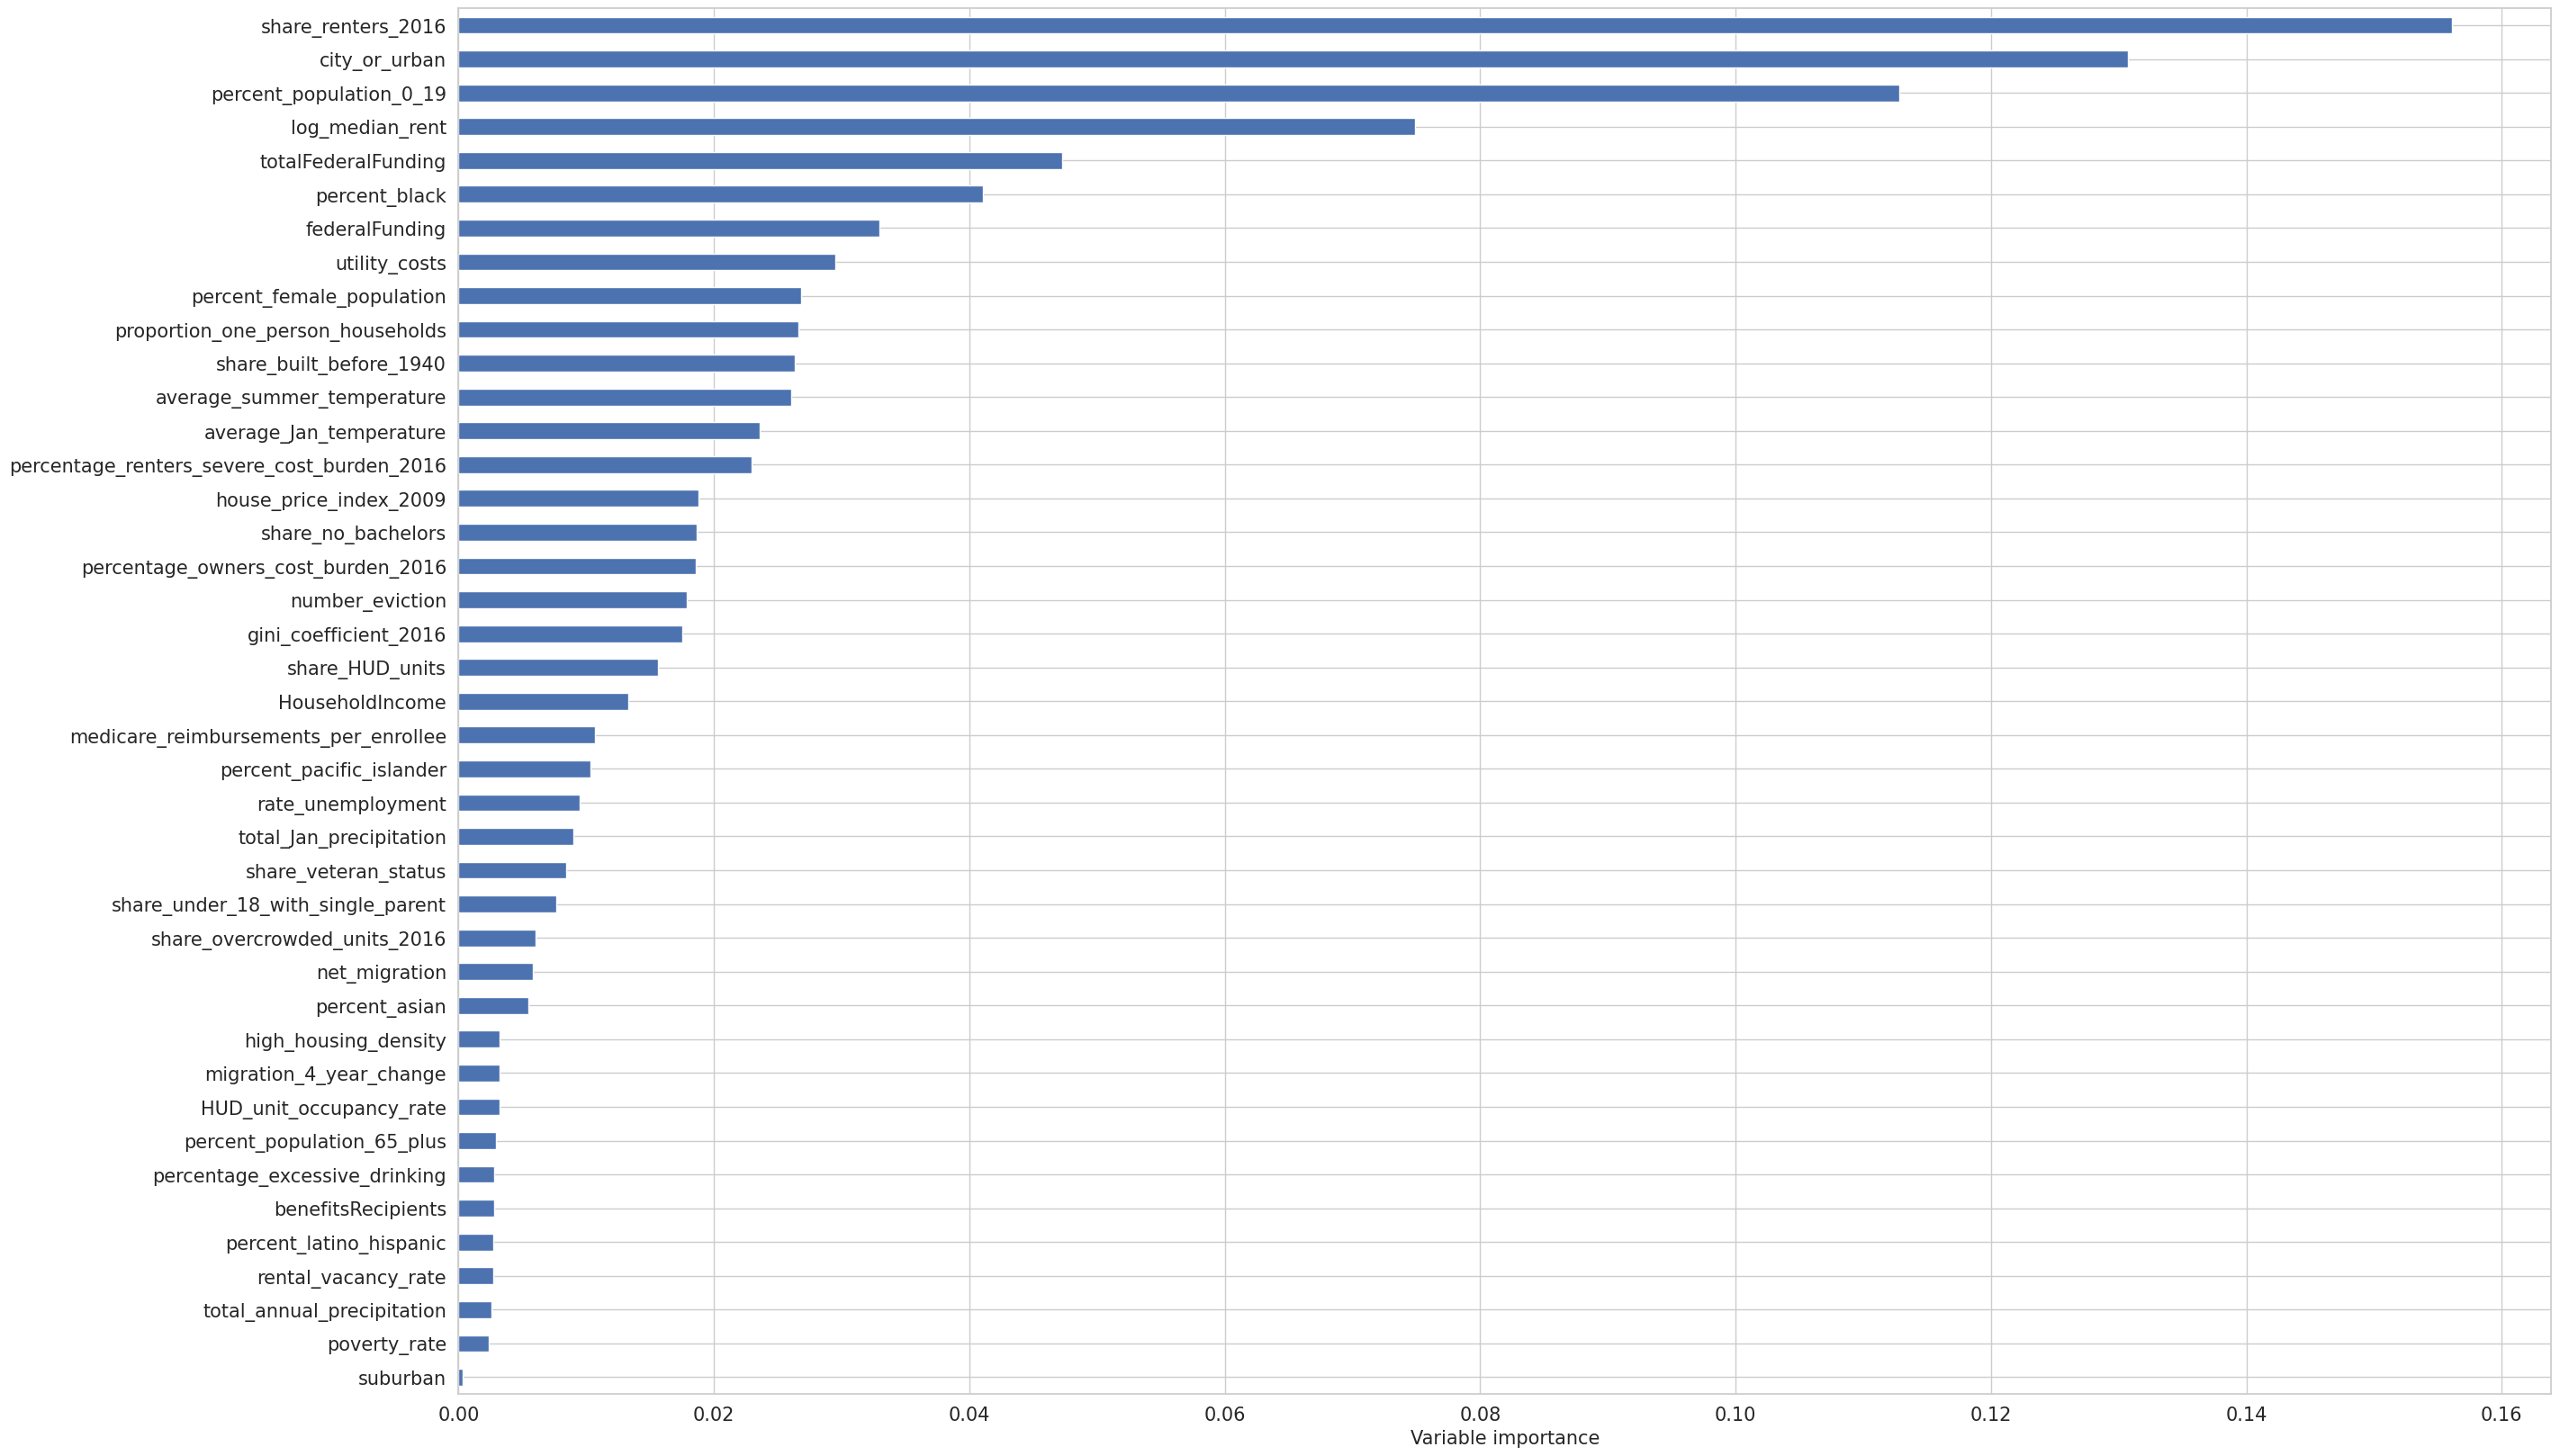

In [148]:
(pd.DataFrame(dict(cols= X.columns, imp=model_xgb.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (30,20)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 15);

The most important variable is share renters of 2016.

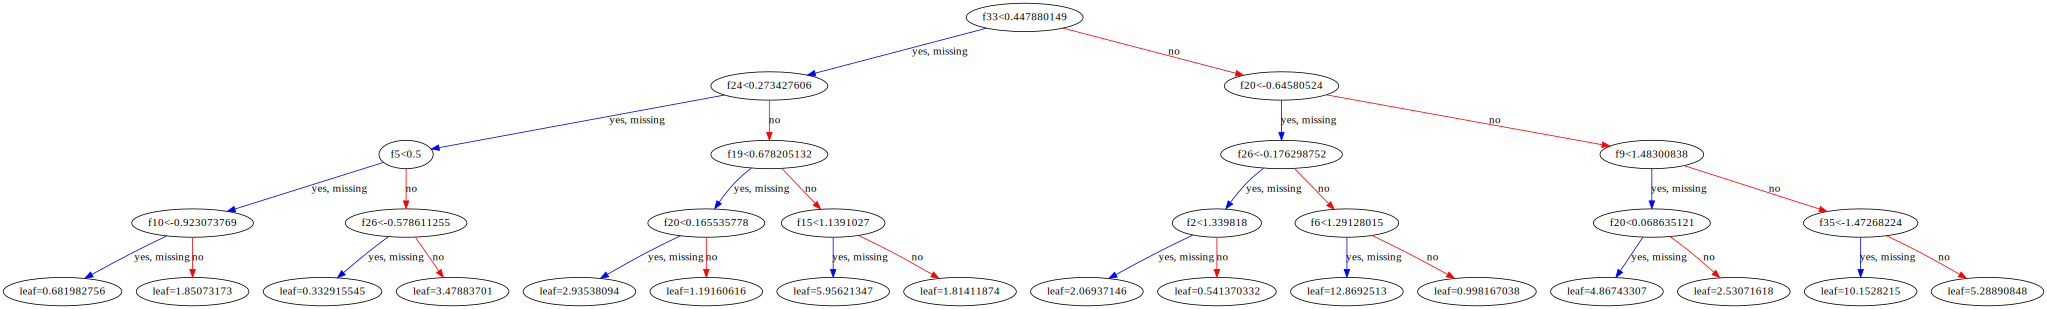

In [149]:
xgb.to_graphviz(model_xgb, num_trees=1) # Try different values of num_trees to plot other trees

This is a tree that represents our XGBoost model. We are making our first split in the tree on the share renters from 2016 variable. We know that this variable is important and highly coupled to the rate of homelessness.

## Additional Step

We included our federal state funding data in our models of regression. However, we will make some graphics to further our exploration of state funding and the rate of homelessness.

We will make a graph that explores the amount of federal funding per resident to the rate of homelessness.

Text(0, 0.5, 'Rate of Homelessness ')

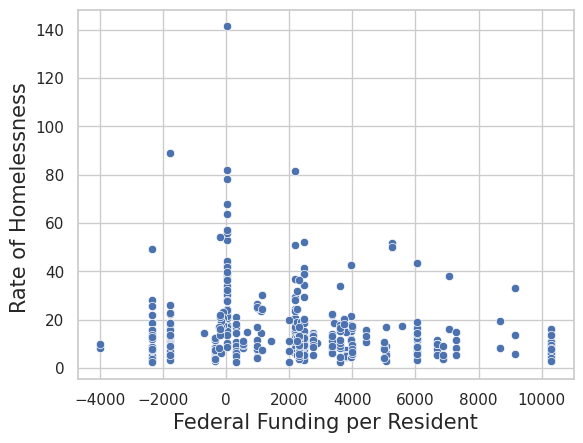

In [150]:
sns.scatterplot(data=df, x='federalFunding', y='rate_homeless')
plt.xlabel('Federal Funding per Resident', fontsize=15)
plt.ylabel('Rate of Homelessness ', fontsize=15)

The data is pretty evenly spread across the amount of federal funding per resident. (Note: A negative federal funding means that is the amount of taxes that a resident pays.)

## Conclusion

The data that we explored was not well fit to the model. We did not create  a model that was more fit then the hud model. We found that the share renters from 2016 variables was closley tied with determining the rate of homelessness. Our additional step of federal funding per resident was not found to be signinicant in our process of predicting the rate of homelessness. Our xgboost had a somewhat accurate prediction of the rate of homelessness, but the r square mean value was high.